In [1]:
from linares_plot import *
import os
import datetime
from datetime import datetime as dt
import re
import statsmodels.formula.api as smf
import random

In [2]:
df = pd.read_excel('C:\\Users\\David\\Desktop\\David\\risa_aplausos\\df_subjects.xlsx')
df.head()

,duration,event,subject,tiempo,time_s,trick,RT,previous_event,anticip_time,next_event,r1,r2,r3,r4
0,1,Se,1,00:00:06,6,1,-1,None,-21,gag,0,0,0,0
1,1,Si,1,00:00:10,10,1,-1,None,-17,gag,0,0,0,0
2,102,N,1,00:00:12,12,1,-1,None,-15,gag,0,0,0,0
3,1,In,1,00:00:32,32,1,5,gag,-2,gag,0,0,0,0
4,1,In,1,00:01:02,62,1,16,inicio,-3,gag,0,0,0,0


In [3]:
##Actions Gea data
df_gea=pd.read_excel(os.getcwd() + '\\EVENTOS_GEA.xlsx', sheet_name='Hoja2' )
times_s = [df_gea.tiempo.iloc[i].minute*60 + df_gea.tiempo.iloc[i].second for i in range(len(df_gea))]
df_gea['times_s'] = times_s

### cambiar tiempo y tiempo_s por los corregidos, en los que se restan 10 minutos, 31 segundos. De esta manera, 
### los dos dataframes están sincronizados

new_times=[]
times_s_new=[]

for i in range(len(df_gea)):
    #print(i)
    h = df_gea.tiempo.iloc[i]
    h_t = str(h.hour) + ':' + str(h.minute) + ':' + str(h.second) 
    substracting = '00:10:31'
    new_time = dt.strptime(h_t, "%H:%M:%S") - dt.strptime(substracting, "%H:%M:%S")
    new_times.append(new_time)
    ##
    times_s_new.append(df_gea.times_s.loc[i] - (60*10 + 31) ) 

    
df_gea['tiempo'] = new_times 
df_gea['times_s'] = times_s_new 

df_gea = df_gea.sort_values(by=['times_s'])

df_gea= df_gea.reset_index()
df_gea = df_gea[['tiempo', 'evento', 'decripcion', 'times_s']]
df_gea['evento_'] = df_gea['evento'].copy()
df_gea['evento_'] = df_gea['evento_'].replace(['Miniclimax', 'Climax final' ], ['climax', 'climax']) #for simplicity
df_gea.head()

,tiempo,evento,decripcion,times_s,evento_
0,00:00:27,gag,broma sobre su dominio del catalán,27,gag
1,00:00:34,gag,"""Por deferencia""",34,gag
2,00:00:46,inicio,Abre el estuche de la baraja,46,inicio
3,00:01:05,gag,"""Que haya público""",65,gag
4,00:01:19,gag,"""El público de schroedinger""",79,gag


In [4]:
## correct number of events
n_total_gags = len(df_gea.loc[df_gea['evento']=='gag'])
n_total_minicl = len(df_gea.loc[df_gea['evento']=='Miniclimax'])
n_total_clfin = len(df_gea.loc[df_gea['evento']=='Climax final'])
n_events_tot = [ n_total_minicl, n_total_clfin, n_total_gags]

In [29]:
df.head()

,duration,event,subject,tiempo,time_s,trick,RT,previous_event,anticip_time,next_event,r1,r2,r3,r4
0,1,Se,1,00:00:06,6,1,-1,None,-21,gag,0,0,0,0
1,1,Si,1,00:00:10,10,1,-1,None,-17,gag,0,0,0,0
2,102,N,1,00:00:12,12,1,-1,None,-15,gag,0,0,0,0
3,1,In,1,00:00:32,32,1,5,gag,-2,gag,0,0,0,0
4,1,In,1,00:01:02,62,1,16,inicio,-3,gag,0,0,0,0


### Shuffled

In [ ]:
##hacer la df_shuffled
## cambias los tiempos en el que el evento sucede (time_s y así quedarán cambiadas tambien las previous y post)
## la haces N veces???

df_subjects_comb_shuff=[]

n_SH=10

df_x=df[['event']].copy()
times_ = df.time_s.values
subjects_ = df.subject.unique()
durations_ = list(df['duration'].values)

for n_shuffles in range(n_SH):
    print(n_shuffles)
    random.shuffle(durations_)
    df_x['duration'] = durations_
    df_x['time_shuff'] = np.random.randint(min(times_), max(times_)+1, len(times_))
    df_x['subjects_shuff'] = np.random.randint(min(subjects_), max(subjects_)+1, len(times_))
    ###################################################### get previous action of the magician and reaction time respect it
    times_after=[]
    prev_event=[]
    for evnt in range(len(df_x)):
        time_ = df_x.iloc[evnt].time_shuff    
        previous_events_gea = df_gea.loc[df_gea['times_s']<=time_]
        if len(previous_events_gea)==0:
            prev_event.append('None')
            times_after.append(-1)
        else:
            previous_event=previous_events_gea.evento.iloc[-1]
            prev_event.append(previous_event)
            time_after = df_x.time_shuff.iloc[evnt] - previous_events_gea.times_s.iloc[-1]
            times_after.append(time_after)
    ##
    df_x['RT'] = times_after
    df_x['previous_event'] = prev_event    
    ###################################################### get future action of the magician and anticiipation time respect it
    next_event=[]
    times_before=[]
    for evnt in range(len(df_x)): 
        time_ = df_x.iloc[evnt].time_shuff    
        posts_events_gea = df_gea.loc[df_gea['times_s']>=time_]
        if len(posts_events_gea)==0:
            next_event.append('None')
            times_before.append(1)
        else:
            next_evnt=posts_events_gea.evento.iloc[0]
            next_event.append(next_evnt)
            time_before = df_x.time_shuff.iloc[evnt] - posts_events_gea.times_s.iloc[0]
            times_before.append(time_before)
    ##
    df_x['anticip_time'] = times_before
    df_x['next_event'] = next_event
    ##
    df_subjects_comb_shuff.append(df_x)
        
##
df_shuff=pd.concat(df_subjects_comb_shuff)
df_shuff.head()

0


In [ ]:
##shuffle time of the events as well as the durations
## random time picked and resampling of durations


In [83]:
EVENTs = ['Miniclimax','Climax final', 'gag']
LABELs = ['sonrisa', 'risa', 'aplauso']


df_a = df.loc[((df['event']=='A')  | (df['event']=='a') | (df['event']=='AA') | (df['event']=='A+') | (df['event']=='AA+') | (df['event']=='a+')) ]
df_a_shuff = df_shuff.loc[((df_shuff['event']=='A')  | (df_shuff['event']=='a') | (df_shuff['event']=='AA') | (df_shuff['event']=='A+') | (df_shuff['event']=='AA+') | (df_shuff['event']=='a+')) ]

df_r = df.loc[df['event']=='R']
df_r_shuff = df_shuff.loc[df_shuff['event']=='R']

df_s = df.loc[df['event']=='S']
df_s_shuff = df_shuff.loc[df_shuff['event']=='S']


dfs_responses = [df_s, df_r, df_a]
dfs_responses_shuff = [df_s_shuff, df_r_shuff, df_a_shuff]
n_events_tot = [ n_total_minicl, n_total_clfin, n_total_gags]


dynamics_ = {}
dynamics_shuff = {}


for idx_label, labels_responses in enumerate(LABELs):
    for idx_event, EVENT in enumerate(EVENTs):
        dfs_ =  [dfs_responses[idx_label], dfs_responses_shuff[idx_label]]
        n_ev = n_events_tot[idx_event]
        print(labels_responses, EVENT)
        #####
        ##### for both the actual data and the shuffle
        #####
        for indx, dfx  in enumerate(dfs_):
            dynamic_post = []
            t_post=45
            events_post =dfx.loc[(dfx['previous_event']==EVENT) & (dfx['RT']<t_post)]
            for i in range(len(events_post)):
                action = np.zeros(t_post) ## 0, in the event time, we will put a 1
                times_=np.arange(0, t_post) ##times (RT always posive)
                ##
                strt = events_post.iloc[i].RT ##starting time after 0
                end_durat = events_post.iloc[i].RT + events_post.iloc[i].duration ## final time after 0 
                ##
                if end_durat < t_post:                              #not very long duration
                    range_action = list(np.arange(strt, end_durat))
                else:                                               #longer duration than the t_post (used for the graph)
                    range_action = list(np.arange(strt, t_post))
                ###
                for x in range_action:    ## change the 0 in the xs for 1 when necessary
                    action[x]=1/n_ev
                ##
                ## dataframe with the time dynamix of the event
                event_x = pd.DataFrame({'times_centered': times_, 'action': action})
                event_x['magician_event'] = events_post.iloc[i].previous_event  
                event_x['reaction'] = EVENT 
                #
                dynamic_post.append(event_x)


            ####
            dynamic_post = pd.concat(dynamic_post)
            ###
            ###
            dynamic_pre = []
            t_pre = -45
            t_post

            events_pre = dfx.loc[(dfx['next_event']==EVENT) & (dfx['anticip_time']>t_pre)]

            for i in range(len(events_pre)):
                action = np.zeros(t_post - t_pre ) ## the sum of both
                times_=np.arange(t_pre, t_post) ##times (RT always posive)
                ##
                strt = events_pre.iloc[i].anticip_time ##starting time after 0
                end_durat = events_pre.iloc[i].anticip_time + events_pre.iloc[i].duration ## final time after 0 
                ##
                if end_durat < t_post:                              #not very long duration
                    range_action = list(np.arange(strt, end_durat))
                else:                                               #longer duration than the t_post (used for the graph)
                    range_action = list(np.arange(strt, t_post))
                ###
                range_action= [range_action[i_x] - t_pre for i_x in range(len(range_action))] ## just in the case of pre
                for x in range_action:    ## change the 0 in the xs for 1 when necessary
                    action[x]=1/n_ev
                ##
                ## dataframe with the time dynamix of the event
                event_x = pd.DataFrame({'times_centered': times_, 'action': action})
                event_x['magician_event'] = events_pre.iloc[i].next_event  
                event_x['reaction'] = EVENT 
                #
                dynamic_pre.append(event_x)


            ####
            dynamic_pre = pd.concat(dynamic_pre)
            ###
            ###
            dynamic=pd.concat([dynamic_post, dynamic_pre])
            str_dict = labels_responses + '___' + EVENT
            
            if indx==0:
                dynamics_[str_dict]= dynamic
            else:
                dynamics_shuff[str_dict]= dynamic

sonrisa Miniclimax
sonrisa Climax final
sonrisa gag
risa Miniclimax
risa Climax final
risa gag
aplauso Miniclimax
aplauso Climax final
aplauso gag


In [85]:
dynamics_.keys()

dict_keys(['sonrisa___Miniclimax', 'sonrisa___gag', 'risa___gag', 'risa___Climax final', 'sonrisa___Climax final', 'aplauso___gag', 'risa___Miniclimax', 'aplauso___Miniclimax', 'aplauso___Climax final'])

In [ ]:
##Individual plot

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


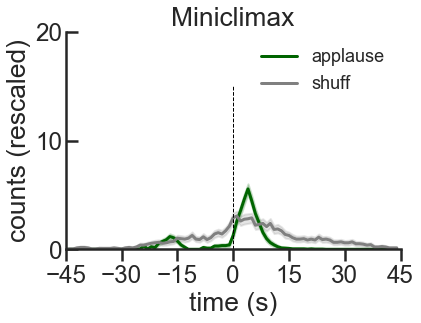

In [89]:
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_['aplauso___Miniclimax'], color='darkgreen', label='applause')
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_shuff['aplauso___Miniclimax'], color='grey', label='shuff')
ylim=20
plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=1)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)  
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params('y', direction='in') #direction
plt.gca().tick_params('x', direction='out') #direction
plt.xlim(-45,45)
plt.xticks([-45, -30, -15, 0, 15, 30, 45])
plt.ylim(0, ylim)
plt.yticks([0,  ylim/2, ylim])
plt.ylabel('counts (rescaled)')
plt.xlabel('time (s)')
plt.legend(loc=1, frameon=False, prop={'size': 18})
plt.title('Miniclimax')
plt.show()

In [ ]:
##3 events plots

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


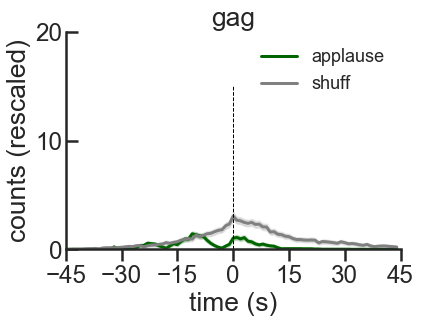

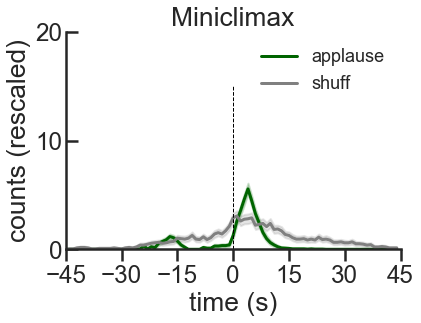

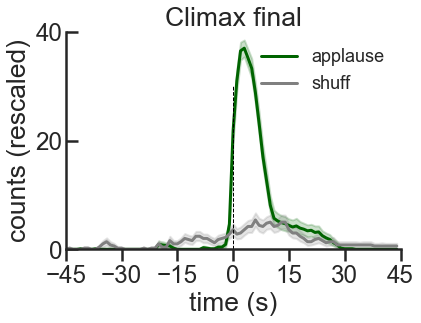

In [93]:
ylims=[20,20,40]
labels_ = ['aplauso___gag','aplauso___Miniclimax', 'aplauso___Climax final' ]
titles_ = ['gag', 'Miniclimax', 'Climax final' ]

for i in range(len(titles_)):
    plt.figure()
    sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_[labels_[i]], color='darkgreen', label='applause')
    sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_shuff[labels_[i]], color='grey', label='shuff')
    ylim=ylims[i]
    plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=1)
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params('y', direction='in') #direction
    plt.gca().tick_params('x', direction='out') #direction
    plt.xlim(-45,45)
    plt.xticks([-45, -30, -15, 0, 15, 30, 45])
    plt.ylim(0, ylim)
    plt.yticks([0,  ylim/2, ylim])
    plt.ylabel('counts (rescaled)')
    plt.xlabel('time (s)')
    plt.legend(loc=1, frameon=False, prop={'size': 18})
    plt.title(titles_[i])
    plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


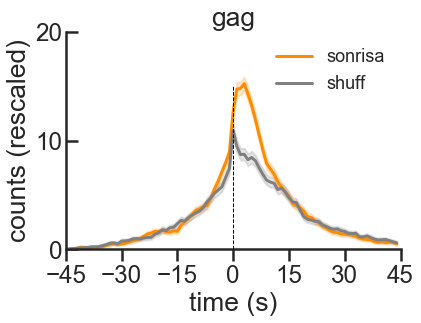

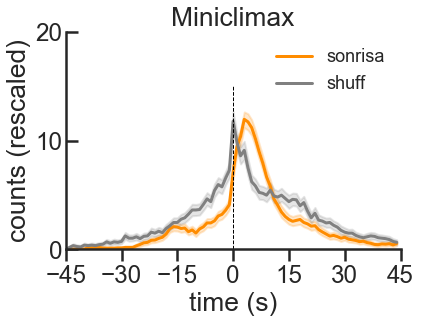

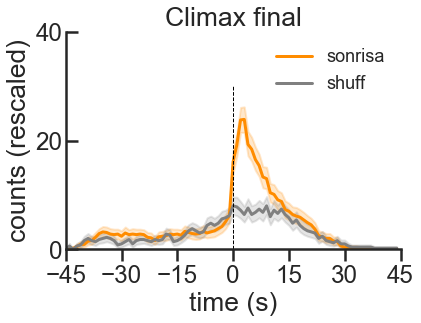

In [94]:
ylims=[20,20,40]
labels_ = ['sonrisa___gag','sonrisa___Miniclimax', 'sonrisa___Climax final' ]
titles_ = ['gag', 'Miniclimax', 'Climax final' ]

for i in range(len(titles_)):
    plt.figure()
    sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_[labels_[i]], color='darkorange', label='sonrisa')
    sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_shuff[labels_[i]], color='grey', label='shuff')
    ylim=ylims[i]
    plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=1)
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params('y', direction='in') #direction
    plt.gca().tick_params('x', direction='out') #direction
    plt.xlim(-45,45)
    plt.xticks([-45, -30, -15, 0, 15, 30, 45])
    plt.ylim(0, ylim)
    plt.yticks([0,  ylim/2, ylim])
    plt.ylabel('counts (rescaled)')
    plt.xlabel('time (s)')
    plt.legend(loc=1, frameon=False, prop={'size': 18})
    plt.title(titles_[i])
    plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


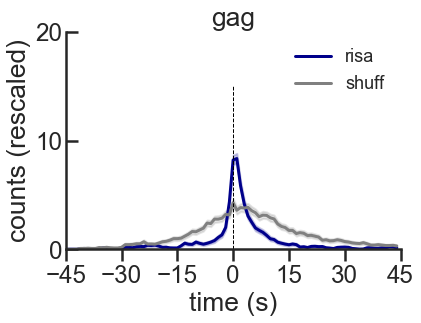

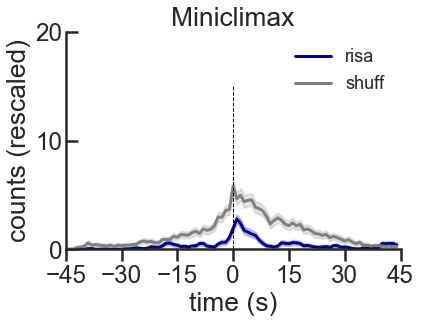

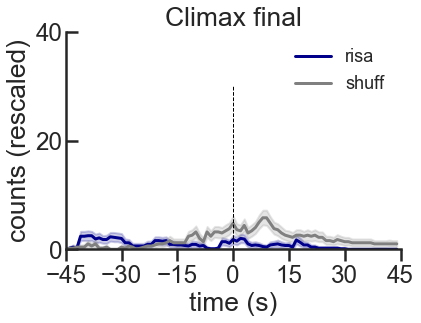

In [95]:
ylims=[20,20,40]
labels_ = ['risa___gag','risa___Miniclimax', 'risa___Climax final' ]
titles_ = ['gag', 'Miniclimax', 'Climax final' ]

for i in range(len(titles_)):
    plt.figure()
    sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_[labels_[i]], color='darkblue', label='risa')
    sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_shuff[labels_[i]], color='grey', label='shuff')
    ylim=ylims[i]
    plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=1)
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params('y', direction='in') #direction
    plt.gca().tick_params('x', direction='out') #direction
    plt.xlim(-45,45)
    plt.xticks([-45, -30, -15, 0, 15, 30, 45])
    plt.ylim(0, ylim)
    plt.yticks([0,  ylim/2, ylim])
    plt.ylabel('counts (rescaled)')
    plt.xlabel('time (s)')
    plt.legend(loc=1, frameon=False, prop={'size': 18})
    plt.title(titles_[i])
    plt.show()

In [79]:
df_a = df.loc[((df['event']=='A')  | (df['event']=='a') | (df['event']=='AA') | (df['event']=='A+') | (df['event']=='AA+') | (df['event']=='a+')) ]
df_a_shuff = df_shuff.loc[((df_shuff['event']=='A')  | (df_shuff['event']=='a') | (df_shuff['event']=='AA') | (df_shuff['event']=='A+') | (df_shuff['event']=='AA+') | (df_shuff['event']=='a+')) ]

labels_responses = 'aplauso'
EVENT= 'Miniclimax'

dynamics_ = []

dfs_responses =  [df_a, df_a_shuff]

n_events_tot = [ n_total_minicl, n_total_clfin, n_total_gags]
n_ev = n_total_minicl

for indx, dfx  in enumerate(dfs_responses):
    dynamic_post = []
    t_post=45

    events_post =dfx.loc[(dfx['previous_event']==EVENT) & (dfx['RT']<t_post)]

    for i in range(len(events_post)):
        action = np.zeros(t_post) ## 0, in the event time, we will put a 1
        times_=np.arange(0, t_post) ##times (RT always posive)
        ##
        strt = events_post.iloc[i].RT ##starting time after 0
        end_durat = events_post.iloc[i].RT + events_post.iloc[i].duration ## final time after 0 
        ##
        if end_durat < t_post:                              #not very long duration
            range_action = list(np.arange(strt, end_durat))
        else:                                               #longer duration than the t_post (used for the graph)
            range_action = list(np.arange(strt, t_post))
        ###
        for x in range_action:    ## change the 0 in the xs for 1 when necessary
            action[x]=1/n_ev
        ##
        ## dataframe with the time dynamix of the event
        event_x = pd.DataFrame({'times_centered': times_, 'action': action})
        event_x['magician_event'] = events_post.iloc[i].previous_event  
        event_x['reaction'] = EVENT 
        #
        dynamic_post.append(event_x)


    ####
    dynamic_post = pd.concat(dynamic_post)
    ###
    ###
    dynamic_pre = []
    t_pre = -45
    t_post

    events_pre = dfx.loc[(dfx['next_event']==EVENT) & (dfx['anticip_time']>t_pre)]

    for i in range(len(events_pre)):
        action = np.zeros(t_post - t_pre ) ## the sum of both
        times_=np.arange(t_pre, t_post) ##times (RT always posive)
        ##
        strt = events_pre.iloc[i].anticip_time ##starting time after 0
        end_durat = events_pre.iloc[i].anticip_time + events_pre.iloc[i].duration ## final time after 0 
        ##
        if end_durat < t_post:                              #not very long duration
            range_action = list(np.arange(strt, end_durat))
        else:                                               #longer duration than the t_post (used for the graph)
            range_action = list(np.arange(strt, t_post))
        ###
        range_action= [range_action[i_x] - t_pre for i_x in range(len(range_action))] ## just in the case of pre
        for x in range_action:    ## change the 0 in the xs for 1 when necessary
            action[x]=1/n_ev
        ##
        ## dataframe with the time dynamix of the event
        event_x = pd.DataFrame({'times_centered': times_, 'action': action})
        event_x['magician_event'] = events_pre.iloc[i].next_event  
        event_x['reaction'] = EVENT 
        #
        dynamic_pre.append(event_x)


    ####
    dynamic_pre = pd.concat(dynamic_pre)
    ###
    ###
    dynamic=pd.concat([dynamic_post, dynamic_pre])
    dynamics_.append(dynamic)




C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


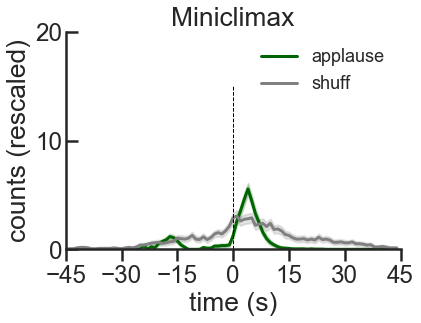

In [80]:
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_[0], color='darkgreen', label='applause')
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_[1], color='grey', label='shuff')
ylim=20
plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=1)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)  
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params('y', direction='in') #direction
plt.gca().tick_params('x', direction='out') #direction
plt.xlim(-45,45)
plt.xticks([-45, -30, -15, 0, 15, 30, 45])
plt.ylim(0, ylim)
plt.yticks([0,  ylim/2, ylim])
plt.ylabel('counts (rescaled)')
plt.xlabel('time (s)')
plt.legend(loc=1, frameon=False, prop={'size': 18})
plt.title('Miniclimax')
plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


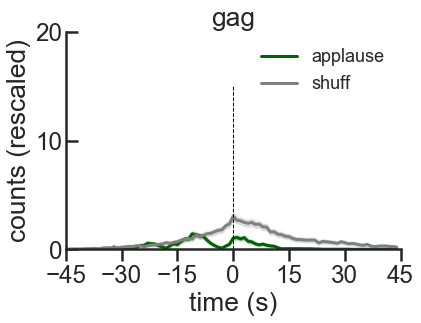

In [78]:
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_[0], color='darkgreen', label='applause')
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_[1], color='grey', label='shuff')
ylim=20
plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=1)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)  
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params('y', direction='in') #direction
plt.gca().tick_params('x', direction='out') #direction
plt.xlim(-45,45)
plt.xticks([-45, -30, -15, 0, 15, 30, 45])
plt.ylim(0, ylim)
plt.yticks([0,  ylim/2, ylim])
plt.ylabel('counts (rescaled)')
plt.xlabel('time (s)')
plt.legend(loc=1, frameon=False, prop={'size': 18})
plt.title('gag')
plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


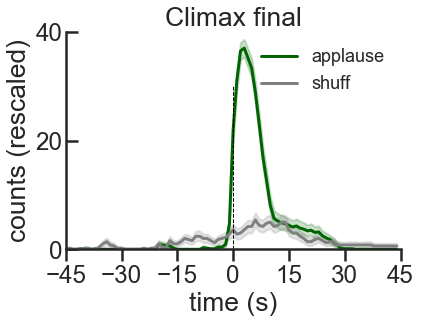

In [71]:
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_[0], color='darkgreen', label='applause')
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamics_[1], color='grey', label='shuff')
ylim=40
plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=1)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)  
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params('y', direction='in') #direction
plt.gca().tick_params('x', direction='out') #direction
plt.xlim(-45,45)
plt.xticks([-45, -30, -15, 0, 15, 30, 45])
plt.ylim(0, ylim)
plt.yticks([0,  ylim/2, ylim])
plt.ylabel('counts (rescaled)')
plt.xlabel('time (s)')
plt.legend(loc=1, frameon=False, prop={'size': 18})
plt.title('Climax final')
plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


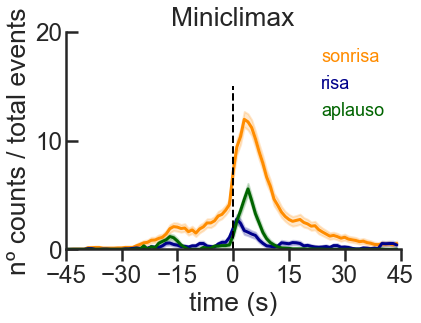

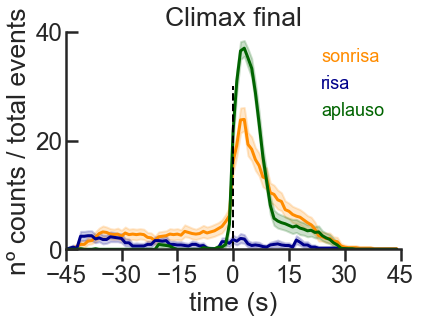

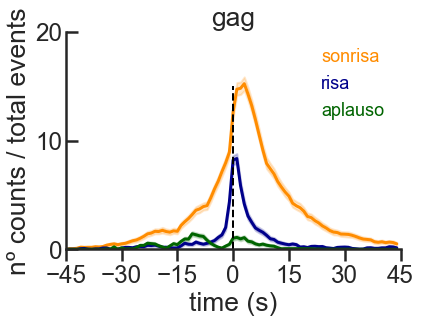

In [56]:
EVENTs = ['Miniclimax','Climax final', 'gag']

df_s = df.loc[df['event']=='S']
df_r = df.loc[df['event']=='R']
df_a = df.loc[((df['event']=='A')  | (df['event']=='a') | (df['event']=='AA') | (df['event']=='A+') | (df['event']=='AA+') | (df['event']=='a+')) ]


dfs_responses = [df_s, df_r, df_a]
labels_responses = ['sonrisa', 'risa', 'aplauso']
colors_ = ['darkorange', 'darkblue', 'darkgreen']



for iev, EVENT in enumerate(EVENTs):
    n_ev = n_events_tot[iev]
    plt.figure()
    for indx, dfx  in enumerate(dfs_responses):
        dynamic_post = []
        t_post=45

        events_post =dfx.loc[(dfx['previous_event']==EVENT) & (dfx['RT']<t_post)]

        for i in range(len(events_post)):
            action = np.zeros(t_post) ## 0, in the event time, we will put a 1
            times_=np.arange(0, t_post) ##times (RT always posive)
            ##
            strt = events_post.iloc[i].RT ##starting time after 0
            end_durat = events_post.iloc[i].RT + events_post.iloc[i].duration ## final time after 0 
            ##
            if end_durat < t_post:                              #not very long duration
                range_action = list(np.arange(strt, end_durat))
            else:                                               #longer duration than the t_post (used for the graph)
                range_action = list(np.arange(strt, t_post))
            ###
            for x in range_action:    ## change the 0 in the xs for 1 when necessary
                action[x]=1/n_ev
            ##
            ## dataframe with the time dynamix of the event
            event_x = pd.DataFrame({'times_centered': times_, 'action': action})
            event_x['magician_event'] = events_post.iloc[i].previous_event  
            event_x['subject'] = events_post.iloc[i].subject 
            event_x['trick'] = events_post.iloc[i].trick 
            event_x['reaction'] = EVENT 
            #
            dynamic_post.append(event_x)


        ####
        dynamic_post = pd.concat(dynamic_post)
        ###
        ###
        dynamic_pre = []
        t_pre = -45
        t_post

        events_pre = dfx.loc[(dfx['next_event']==EVENT) & (dfx['anticip_time']>t_pre)]

        for i in range(len(events_pre)):
            action = np.zeros(t_post - t_pre ) ## the sum of both
            times_=np.arange(t_pre, t_post) ##times (RT always posive)
            ##
            strt = events_pre.iloc[i].anticip_time ##starting time after 0
            end_durat = events_pre.iloc[i].anticip_time + events_pre.iloc[i].duration ## final time after 0 
            ##
            if end_durat < t_post:                              #not very long duration
                range_action = list(np.arange(strt, end_durat))
            else:                                               #longer duration than the t_post (used for the graph)
                range_action = list(np.arange(strt, t_post))
            ###
            range_action= [range_action[i_x] - t_pre for i_x in range(len(range_action))] ## just in the case of pre
            for x in range_action:    ## change the 0 in the xs for 1 when necessary
                action[x]=1/n_ev
            ##
            ## dataframe with the time dynamix of the event
            event_x = pd.DataFrame({'times_centered': times_, 'action': action})
            event_x['magician_event'] = events_pre.iloc[i].next_event  
            event_x['subject'] = events_pre.iloc[i].subject 
            event_x['trick'] = events_pre.iloc[i].trick 
            event_x['reaction'] = EVENT 
            #
            dynamic_pre.append(event_x)


        ####
        dynamic_pre = pd.concat(dynamic_pre)
        ###
        ###
        dynamic=pd.concat([dynamic_post, dynamic_pre])
        
        sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamic, color=colors_[indx], label=labels_responses[indx])
    ##
    ###
    if EVENT =='gag':
        ylim = 20
    elif EVENT == 'Miniclimax':
        ylim = 20
    elif EVENT == 'Climax final':
        ylim=40
    
    plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=2)
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params('y', direction='in') #direction
    plt.gca().tick_params('x', direction='out') #direction
    plt.xlim(-45,45)
    plt.xticks([-45, -30, -15, 0, 15, 30, 45])
    plt.ylim(0, ylim)
    plt.yticks([0,  ylim/2, ylim])
    plt.ylabel('nº counts / total events')
    plt.xlabel('time (s)')
    plt.title(EVENT)
    #
    l = plt.legend(loc=1, frameon=False, prop={'size': 18})
    for i_h, h_idx in enumerate(labels_responses):
        l.get_texts()[i_h].set_text(h_idx)
        l.legendHandles[i_h].set_visible(False);
        l.get_texts()[i_h].set_color(colors_[i_h]);
    ##
    plt.show()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


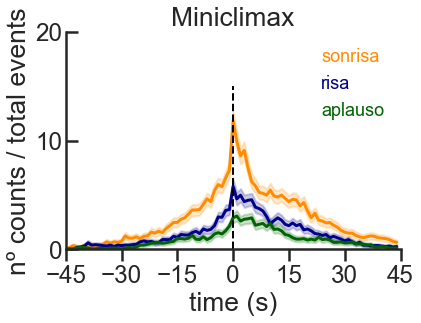

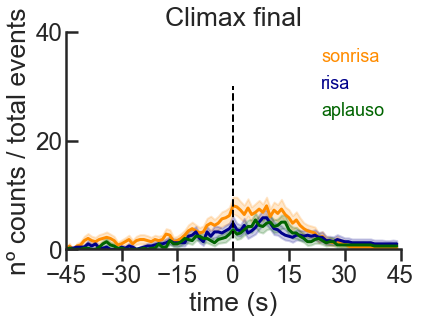

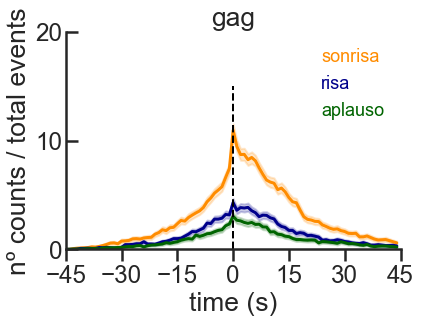

In [53]:
EVENTs = ['Miniclimax','Climax final', 'gag']

df_s = df_shuff.loc[df_shuff['event']=='S']
df_r = df_shuff.loc[df_shuff['event']=='R']
df_a = df_shuff.loc[((df_shuff['event']=='A')  | (df_shuff['event']=='a') | (df_shuff['event']=='AA') | (df_shuff['event']=='A+') | (df_shuff['event']=='AA+') | (df_shuff['event']=='a+')) ]


dfs_responses = [df_s, df_r, df_a]
labels_responses = ['sonrisa', 'risa', 'aplauso']
colors_ = ['darkorange', 'darkblue', 'darkgreen']



for iev, EVENT in enumerate(EVENTs):
    n_ev = n_events_tot[iev]
    plt.figure()
    for indx, dfx  in enumerate(dfs_responses):
        dynamic_post = []
        t_post=45

        events_post =dfx.loc[(dfx['previous_event']==EVENT) & (dfx['RT']<t_post)]

        for i in range(len(events_post)):
            action = np.zeros(t_post) ## 0, in the event time, we will put a 1
            times_=np.arange(0, t_post) ##times (RT always posive)
            ##
            strt = events_post.iloc[i].RT ##starting time after 0
            end_durat = events_post.iloc[i].RT + events_post.iloc[i].duration ## final time after 0 
            ##
            if end_durat < t_post:                              #not very long duration
                range_action = list(np.arange(strt, end_durat))
            else:                                               #longer duration than the t_post (used for the graph)
                range_action = list(np.arange(strt, t_post))
            ###
            for x in range_action:    ## change the 0 in the xs for 1 when necessary
                action[x]=1/n_ev
            ##
            ## dataframe with the time dynamix of the event
            event_x = pd.DataFrame({'times_centered': times_, 'action': action})
            event_x['magician_event'] = events_post.iloc[i].previous_event  
            #event_x['subject'] = events_post.iloc[i].subject 
            #event_x['trick'] = events_post.iloc[i].trick 
            event_x['reaction'] = EVENT 
            #
            dynamic_post.append(event_x)


        ####
        dynamic_post = pd.concat(dynamic_post)
        ###
        ###
        dynamic_pre = []
        t_pre = -45
        t_post

        events_pre = dfx.loc[(dfx['next_event']==EVENT) & (dfx['anticip_time']>t_pre)]

        for i in range(len(events_pre)):
            action = np.zeros(t_post - t_pre ) ## the sum of both
            times_=np.arange(t_pre, t_post) ##times (RT always posive)
            ##
            strt = events_pre.iloc[i].anticip_time ##starting time after 0
            end_durat = events_pre.iloc[i].anticip_time + events_pre.iloc[i].duration ## final time after 0 
            ##
            if end_durat < t_post:                              #not very long duration
                range_action = list(np.arange(strt, end_durat))
            else:                                               #longer duration than the t_post (used for the graph)
                range_action = list(np.arange(strt, t_post))
            ###
            range_action= [range_action[i_x] - t_pre for i_x in range(len(range_action))] ## just in the case of pre
            for x in range_action:    ## change the 0 in the xs for 1 when necessary
                action[x]=1/n_ev
            ##
            ## dataframe with the time dynamix of the event
            event_x = pd.DataFrame({'times_centered': times_, 'action': action})
            event_x['magician_event'] = events_pre.iloc[i].next_event  
            #event_x['subject'] = events_pre.iloc[i].subject 
            #event_x['trick'] = events_pre.iloc[i].trick 
            event_x['reaction'] = EVENT 
            #
            dynamic_pre.append(event_x)


        ####
        dynamic_pre = pd.concat(dynamic_pre)
        ###
        ###
        dynamic=pd.concat([dynamic_post, dynamic_pre])
        
        sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamic, color=colors_[indx], label=labels_responses[indx])
    ##
    ###
    if EVENT =='gag':
        ylim = 20
    elif EVENT == 'Miniclimax':
        ylim = 20
    elif EVENT == 'Climax final':
        ylim=40
    
    plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=2)
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params('y', direction='in') #direction
    plt.gca().tick_params('x', direction='out') #direction
    plt.xlim(-45,45)
    plt.xticks([-45, -30, -15, 0, 15, 30, 45])
    plt.ylim(0, ylim)
    plt.yticks([0,  ylim/2, ylim])
    plt.ylabel('nº counts / total events')
    plt.xlabel('time (s)')
    plt.title(EVENT)
    #
    l = plt.legend(loc=1, frameon=False, prop={'size': 18})
    for i_h, h_idx in enumerate(labels_responses):
        l.get_texts()[i_h].set_text(h_idx)
        l.legendHandles[i_h].set_visible(False);
        l.get_texts()[i_h].set_color(colors_[i_h]);
    ##
    plt.show()

In [55]:
dynamic_shuff = dynamic.copy()

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


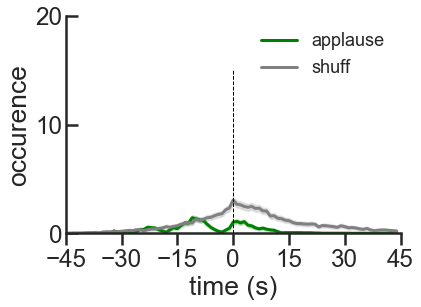

In [58]:
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamic, color='green', label='applause')
sns.lineplot('times_centered', 'action', estimator=np.sum, data=dynamic_shuff, color='grey', label='shuff')
ylim=20
plt.plot([0,0], [0, ylim-0.25*ylim], '--k', linewidth=1)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)  
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params('y', direction='in') #direction
plt.gca().tick_params('x', direction='out') #direction
plt.xlim(-45,45)
plt.xticks([-45, -30, -15, 0, 15, 30, 45])
plt.ylim(0, ylim)
plt.yticks([0,  ylim/2, ylim])
plt.ylabel('counts (rescaled)')
plt.xlabel('time (s)')
plt.legend(loc=1, frameon=False, prop={'size': 18})
plt.title('gag')
plt.show()